In [1]:
import sys

sys.path.insert(0, "..")

from dinov2.data.loaders import make_dataset
import matplotlib.pyplot as plt
from dinov2.data import DataAugmentationDINO

import numpy as np
import torch

from dinov2.data.masking import MaskingGenerator
from dinov2.data.collate import collate_data_and_cast
from dinov2.data import make_data_loader

from functools import partial

from dinov2.models.vision_transformer import DinoVisionTransformer

from dinov2.layers import (
    MemEffAttention,
    Mlp,
    PatchEmbed,
    SwiGLUFFNFused,
)
from dinov2.layers import (
    NestedTensorBlock as Block,
)


root = "/home/jluesch/Documents/data/plankton/nat_lmdb/"
ds_path = f"LMDBDataset:split=TRAIN:root={root}:extra=*"

/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submi

In [2]:
global_crops_size = 224
local_crops_size = 98
patch_size = 14

data_transform_cpu = DataAugmentationDINO(
    global_crops_scale=[0.32, 0.8],
    local_crops_scale=[0.05, 0.32],
    local_crops_number=6,
    global_crops_size=global_crops_size,
    local_crops_size=local_crops_size,
    use_kornia=True,
    use_native_res=True,
    do_seg_crops=True,
    patch_size=patch_size,
)

dataset = make_dataset(
    dataset_str=ds_path,
    transform=data_transform_cpu,
    target_transform=lambda x: (),
    with_targets=False,
    cache_dataset=False,
)

Dataset kwargs {'split': <_Split.TRAIN: 'train'>, 'root': '/home/jluesch/Documents/data/plankton/nat_lmdb/', 'extra': '*'}
extra_path /home/jluesch/Documents/data/plankton/nat_lmdb/*-TRAIN_*
Datasets labels file list:  ['/home/jluesch/Documents/data/plankton/nat_lmdb/2007-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2008-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2009-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2010-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2011-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2012-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2013-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2014-TRAIN_labels']
Datasets imgs file list:  ['/home/jluesch/Documents/data/plankton/nat_lmdb/2007-TRAIN_imgs', '/home/jluesch/Documents/data/plankton/nat_lmdb/2008-TRAIN_imgs', '/home/jluesch/Documents/data/plankton/nat_lmdb/2009-TRAIN_imgs', '/home/jlue

In [10]:
nb_patches_gc = global_crops_size // patch_size

mask_generator = MaskingGenerator(
    input_size=(nb_patches_gc, nb_patches_gc),
    max_num_patches=0.5 * nb_patches_gc * nb_patches_gc,
)


def list_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]


n_tokens = (global_crops_size // patch_size) ** 2
collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=(0.1, 0.5),
    mask_probability=0.5,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=torch.half,
    free_shapes=True,
)

data_loader = make_data_loader(
    dataset=dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    seed=0,
    sampler_type=None,
    sampler_advance=0,
    drop_last=True,
    collate_fn=collate_fn,
)

In [11]:
model = DinoVisionTransformer(
    patch_size=patch_size,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    block_fn=partial(Block, attn_class=MemEffAttention),
    num_register_tokens=0,
    img_size=global_crops_size,
    in_chans=3,
    drop_path_rate=0.0,
    drop_path_uniform=True,
    init_values=1.0e-05,  # for layerscale: None or 0 => no layerscale
    embed_layer=PatchEmbed,
    ffn_layer="mlp",
    block_chunks=1,
    interpolate_antialias=False,
    interpolate_offset=0.1,
)

In [16]:
mem_list, max_mem_list, shapes_list = [], [], []
model.cuda()
with torch.cuda.amp.autocast():
    with torch.no_grad():
        for i, el in enumerate(data_loader):
            if not i % 25:
                print(i)
            if i > 300:
                break
            if isinstance(el, list):
                el = el[0]
            if isinstance(el, dict):
                collated_dict = el

            # list of len batch size containing dicts
            # collated_dict = collate_fn(el)

            mem_list.append(np.round(torch.cuda.memory_allocated() / 1024 / 1024, 2))
            max_mem_list.append(
                np.round(torch.cuda.max_memory_allocated() / 1024 / 1024, 2)
            )
            shapes_list.append(collated_dict['collated_global_crops'].size(-1))

            out = model(
                [
                    collated_dict["collated_global_crops"].cuda(),
                    collated_dict["collated_local_crops"].cuda(),
                ],
                masks=[collated_dict["collated_masks"].cuda(), None],
                is_training=True,
                # attn_masks=[collated_dict["attn_mask_gc"].cuda(),collated_dict["attn_mask_lc"].cuda()]
            )
            # print("out gc + lc", out[0]["x_norm_clstoken"].shape)

            out = model(
                collated_dict["collated_global_crops"].cuda(),
                masks=collated_dict["collated_masks"].cuda(),
                is_training=True,
                # attn_masks=[collated_dict["attn_mask_gc"].cuda(),collated_dict["attn_mask_lc"].cuda()]
            )
            # print("out gc", out["x_norm_clstoken"].shape)

coll_global_crops torch.Size([32, 3, 14, 4032])
coll_local_crops torch.Size([16, 3, 14, 4032])
coll_global_crops torch.Size([32, 3, 14, 4060])
coll_local_crops torch.Size([16, 3, 14, 4060])
0
coll_global_crops torch.Size([32, 3, 14, 4032])
coll_local_crops torch.Size([16, 3, 14, 4032])
coll_global_crops torch.Size([32, 3, 14, 4032])
coll_local_crops torch.Size([16, 3, 14, 4032])
coll_global_crops torch.Size([32, 3, 14, 4900])
coll_local_crops torch.Size([16, 3, 14, 4900])
coll_global_crops torch.Size([32, 3, 14, 4144])
coll_local_crops torch.Size([16, 3, 14, 4144])
25
coll_global_crops torch.Size([32, 3, 14, 4060])
coll_local_crops torch.Size([16, 3, 14, 4060])
50
coll_global_crops torch.Size([32, 3, 14, 4032])
coll_local_crops torch.Size([16, 3, 14, 4032])
coll_global_crops torch.Size([32, 3, 14, 4900])
coll_local_crops torch.Size([16, 3, 14, 4900])
75
100
coll_global_crops torch.Size([32, 3, 14, 4032])
coll_local_crops torch.Size([16, 3, 14, 4032])
coll_global_crops torch.Size([32, 3

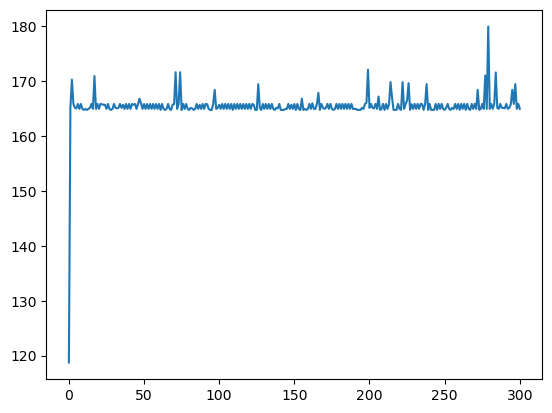

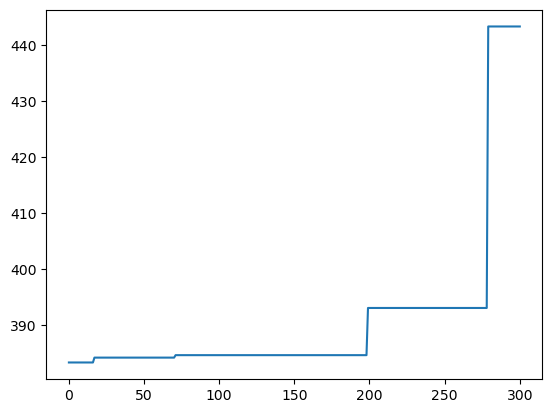

In [17]:
plt.plot(mem_list)
plt.show()
plt.plot(max_mem_list)
plt.show()

In [9]:
for i in range(len(out)):
    for k in out[i].keys():
        if out[i][k] is not None:
            print(k, out[i][k].shape)

KeyError: 0